In [1]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

In [2]:
from mario2 import MyMarioEnvironment2

In [3]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        
        self.value = nn.Linear(in_features=64, out_features=1)

        self.advantage = nn.Linear(in_features=64, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        val = self.relu(self.fc2(x))
        val = self.value(val)

        adv = self.relu(self.fc2(x))
        adv = self.advantage(adv)
        q_val = val + adv - adv.mean(dim=1, keepdim=True)
        return q_val.float()  

In [26]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

In [13]:
class GridDuelingDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.90
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=2500
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      obs,aud = self.env.reset()
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) 
      self.q_value_dqn = DQN_FC(lenn, self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False, max_ep=10):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))
      
      self.test_max_episodes = max_ep
      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0)
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          # self.env.render(mode="human", save=True, step=steps)
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0)

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      # with torch.no_grad():
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1]))
      best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)
      next_q_value_list = self.target_dqn(next_state_batch)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud_obs = self.env.reset()
        obs.extend(aud_obs)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) 

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          # q_value_dict = self.q_value_dqn.state_dict()
          # target_dict = self.target_dqn.state_dict()
        
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0,)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.FloatTensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.FloatTensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [ ]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
a = GridDuelingDQN(env)
a.learn()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:18<05:38,  7.09episodes/s]

Buffer_size: 2500|Train_time:0.004251000881195069| Sub_t:0.004661374092102051
[Episode: 100] - Steps: 29.69 | Rewards: -7.04 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 202/2500 [00:32<04:20,  8.81episodes/s]

Buffer_size: 2500|Train_time:0.004064412117004395| Sub_t:0.004531457424163819
[Episode: 200] - Steps: 27.71 | Rewards: 0.02 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:45<04:57,  7.38episodes/s]

Buffer_size: 2500|Train_time:0.003927607536315918| Sub_t:0.004474916458129883
[Episode: 300] - Steps: 26.32 | Rewards: 2.65 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 402/2500 [00:56<02:54, 12.05episodes/s]

Buffer_size: 2500|Train_time:0.004051899909973145| Sub_t:0.004632561206817627
[Episode: 400] - Steps: 20.35 | Rewards: 9.02 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [01:05<02:51, 11.68episodes/s]

Buffer_size: 2500|Train_time:0.004120700359344483| Sub_t:0.004803521633148193
[Episode: 500] - Steps: 18.66 | Rewards: 11.66 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 602/2500 [01:14<03:12,  9.86episodes/s]

Buffer_size: 2500|Train_time:0.00459050178527832| Sub_t:0.0052245140075683595
[Episode: 600] - Steps: 17.31 | Rewards: 12.61 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 701/2500 [01:23<02:07, 14.08episodes/s]

Buffer_size: 2500|Train_time:0.004133756160736084| Sub_t:0.004804103374481201
[Episode: 700] - Steps: 17.92 | Rewards: 13.04 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 802/2500 [01:29<01:48, 15.61episodes/s]

Buffer_size: 2500|Train_time:0.004280309677124023| Sub_t:0.004899060726165772
[Episode: 800] - Steps: 13.28 | Rewards: 14.73 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 903/2500 [01:37<02:05, 12.76episodes/s]

Buffer_size: 2500|Train_time:0.003957343101501465| Sub_t:0.004662649631500244
[Episode: 900] - Steps: 15.98 | Rewards: 14.09 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1002/2500 [01:44<01:42, 14.56episodes/s]

Buffer_size: 2500|Train_time:0.004147412776947021| Sub_t:0.004790241718292236
[Episode: 1000] - Steps: 13.64 | Rewards: 15.0 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:51<02:01, 11.51episodes/s]

Buffer_size: 2500|Train_time:0.0037442612648010253| Sub_t:0.004402105808258057
[Episode: 1100] - Steps: 14.49 | Rewards: 14.36 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1202/2500 [01:58<01:28, 14.63episodes/s]

Buffer_size: 2500|Train_time:0.004809739589691162| Sub_t:0.0055637359619140625
[Episode: 1200] - Steps: 14.35 | Rewards: 15.28 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1302/2500 [02:05<01:28, 13.60episodes/s]

Buffer_size: 2500|Train_time:0.004024989604949951| Sub_t:0.0048108863830566406
[Episode: 1300] - Steps: 12.95 | Rewards: 14.88 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1403/2500 [02:11<01:04, 16.94episodes/s]

Buffer_size: 2500|Train_time:0.004080333709716797| Sub_t:0.0048531627655029295
[Episode: 1400] - Steps: 13.76 | Rewards: 14.06 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1502/2500 [02:18<00:52, 19.10episodes/s]

Buffer_size: 2500|Train_time:0.00414163589477539| Sub_t:0.004795284271240235
[Episode: 1500] - Steps: 11.92 | Rewards: 15.45 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1603/2500 [02:24<01:07, 13.34episodes/s]

Buffer_size: 2500|Train_time:0.004665999412536621| Sub_t:0.005342025756835938
[Episode: 1600] - Steps: 13.25 | Rewards: 14.8 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1703/2500 [02:32<00:58, 13.65episodes/s]

Buffer_size: 2500|Train_time:0.0038770103454589845| Sub_t:0.004568269252777099
[Episode: 1700] - Steps: 14.09 | Rewards: 13.75 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1801/2500 [02:37<00:43, 16.17episodes/s]

Buffer_size: 2500|Train_time:0.004007804393768311| Sub_t:0.004702129364013672
[Episode: 1800] - Steps: 10.71 | Rewards: 15.76 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1902/2500 [02:46<00:37, 15.76episodes/s]

Buffer_size: 2500|Train_time:0.004321665763854981| Sub_t:0.005147151947021485
[Episode: 1900] - Steps: 15.31 | Rewards: 13.41 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [02:54<00:34, 14.44episodes/s]

Buffer_size: 2500|Train_time:0.005927295684814453| Sub_t:0.00683354377746582
[Episode: 2000] - Steps: 12.4 | Rewards: 14.51 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2102/2500 [03:01<00:21, 18.69episodes/s]

Buffer_size: 2500|Train_time:0.004146881103515625| Sub_t:0.004912095069885254
[Episode: 2100] - Steps: 13.93 | Rewards: 14.21 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2203/2500 [03:08<00:17, 16.73episodes/s]

Buffer_size: 2500|Train_time:0.004433422088623047| Sub_t:0.005159649848937988
[Episode: 2200] - Steps: 12.09 | Rewards: 15.16 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [03:15<00:15, 12.45episodes/s]

Buffer_size: 2500|Train_time:0.003974878787994384| Sub_t:0.004626343250274658
[Episode: 2300] - Steps: 15.0 | Rewards: 13.95 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2400/2500 [03:24<00:06, 14.84episodes/s]

Buffer_size: 2500|Train_time:0.004387135505676269| Sub_t:0.0051581478118896485
[Episode: 2400] - Steps: 15.26 | Rewards: 12.28 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [03:30<00:00, 11.88episodes/s]

Buffer_size: 2500|Train_time:0.003164935111999512| Sub_t:0.0037924528121948244
[Episode: 2500] - Steps: 10.73 | Rewards: 16.0 | Epsilon: 0.01000000000000053 | loss: 0.000


In [6]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

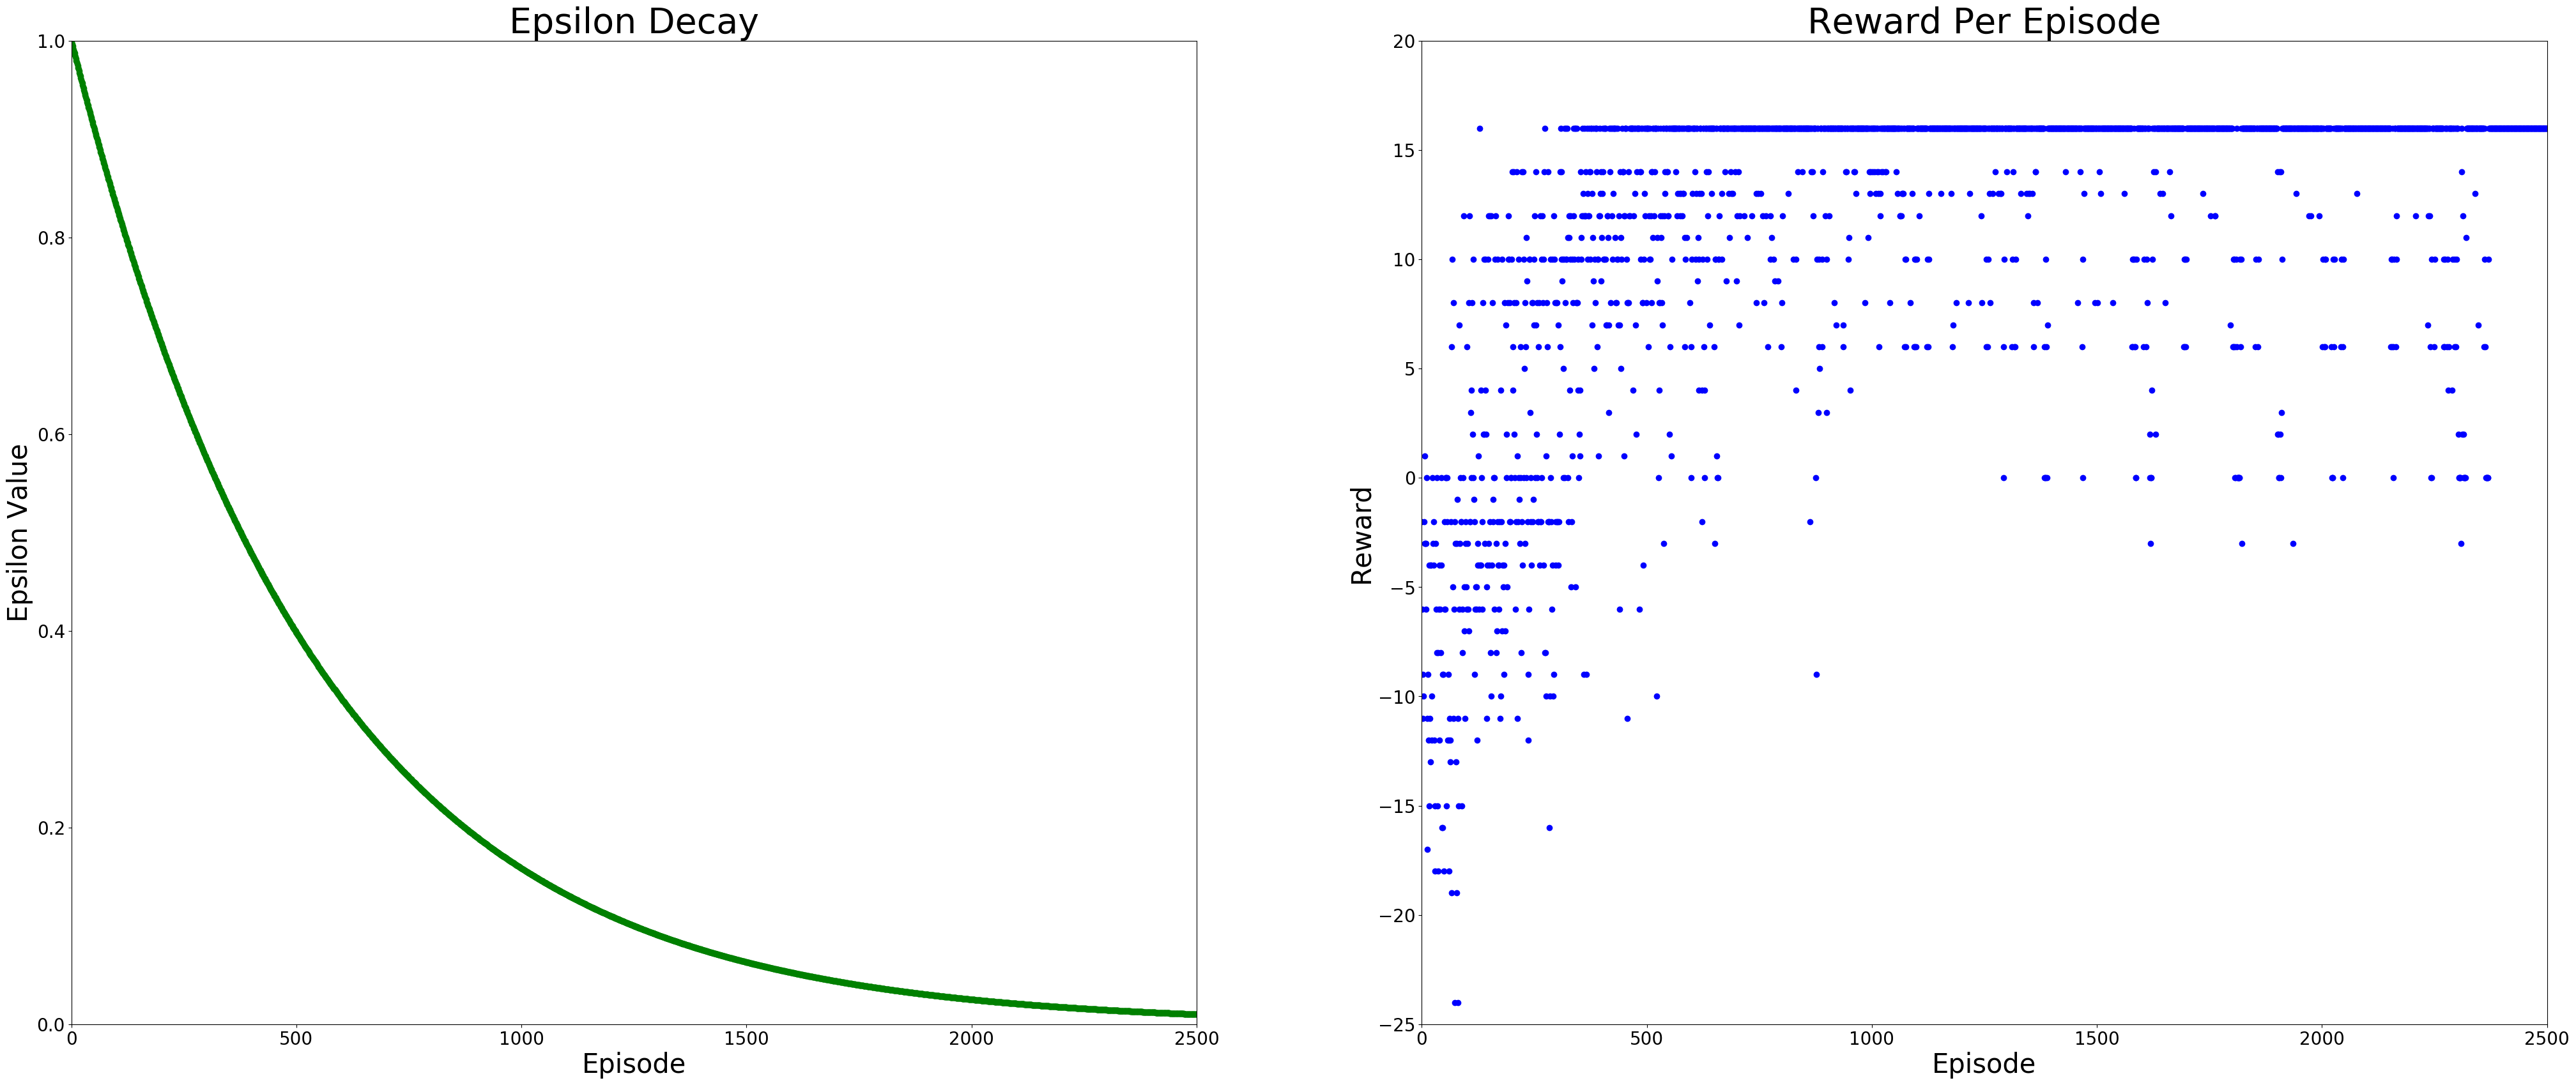

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

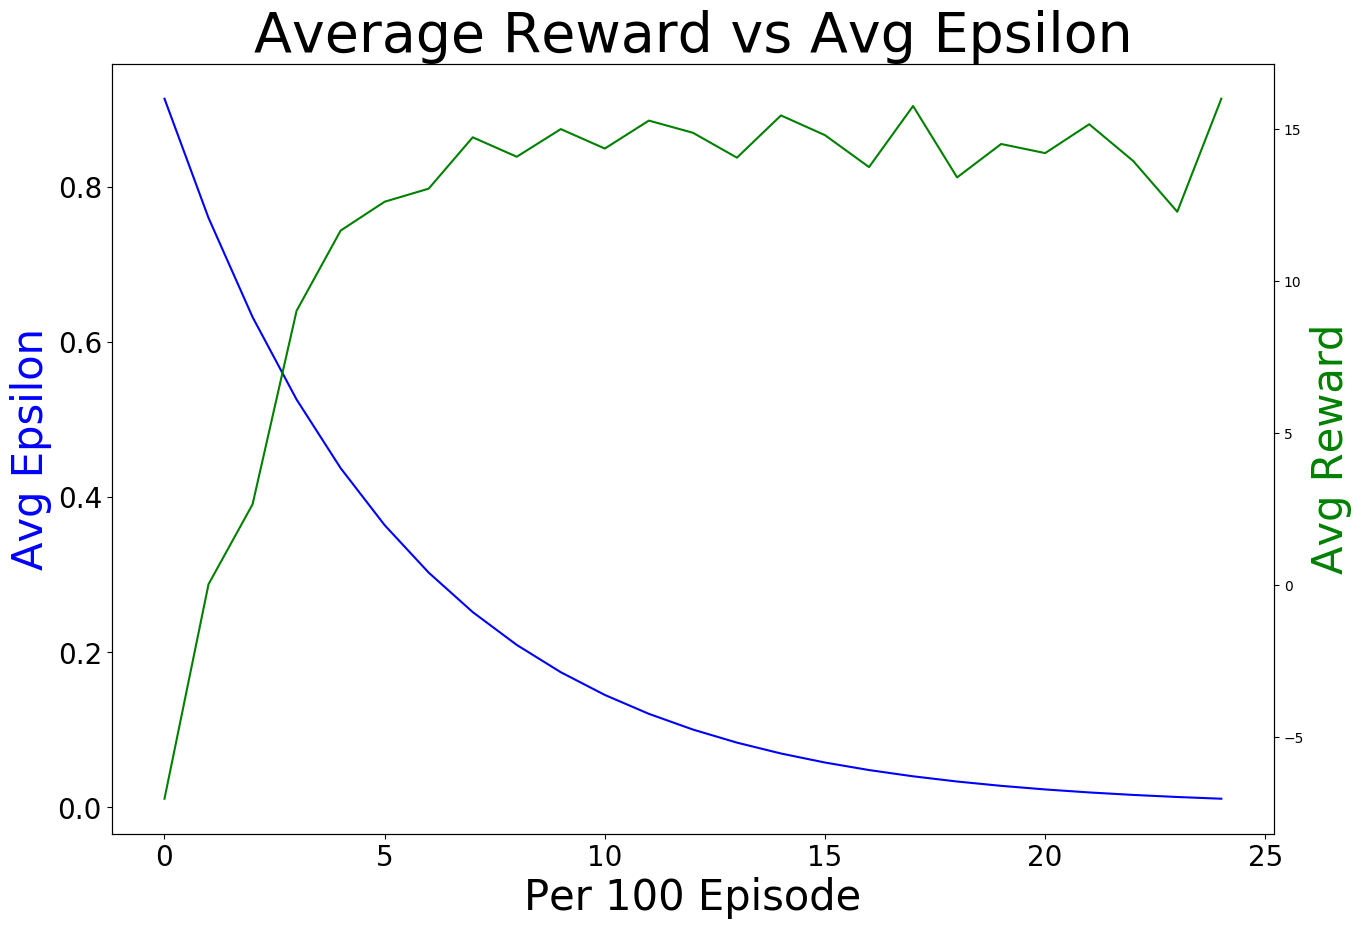

In [8]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [12]:
import json
with open('reward_dueling.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

In [9]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

In [14]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
a = GridDuelingDQN(env)
a.eval(load=True, max_ep=10)

100%|██████████| 10/10 [00:00<00:00, 69.04episodes/s]


In [15]:
reward_list_test_dqn = a.test_rewards_list

<Figure size 640x480 with 0 Axes>

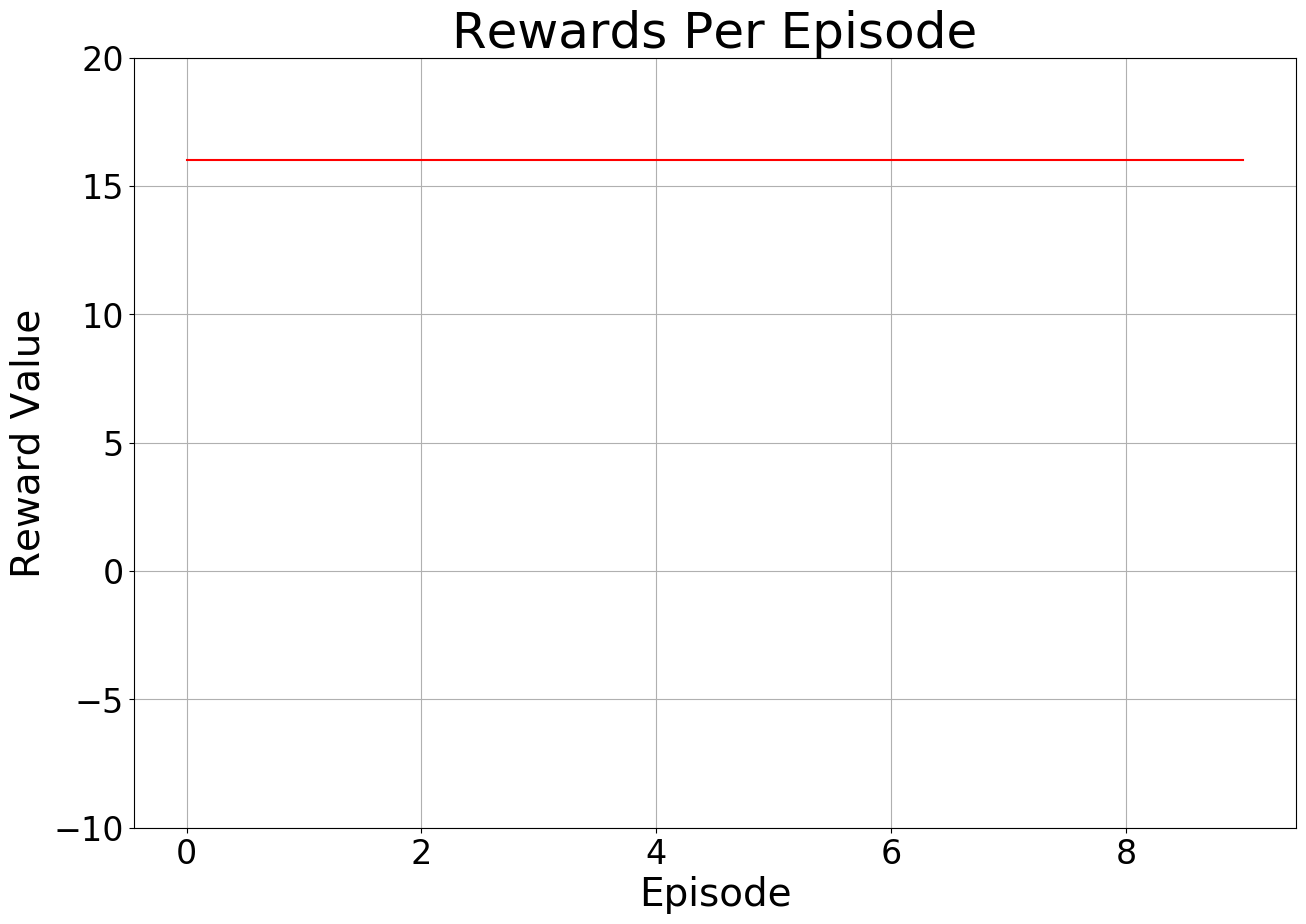

In [16]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()